<a href="https://colab.research.google.com/github/psmouli14/final_project/blob/main/Cifar_prototype_reptile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
from PIL import Image
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
from google.colab import files
uploaded = files.upload()

Saving cifar-100-python.tar.gz to cifar-100-python.tar.gz


In [3]:
!tar -zxvf cifar-100-python.tar.gz

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [5]:
meta = unpickle('cifar-100-python/meta')
train = unpickle('cifar-100-python/train')
test = unpickle('cifar-100-python/test')

In [6]:
meta_keys = list(meta.keys())
meta_keys

[b'fine_label_names', b'coarse_label_names']

In [7]:
Classes = pd.DataFrame(meta[b'fine_label_names'],columns = ['Classes'])

In [8]:
len(Classes)

100

In [9]:
training_keys = list(train.keys())
training_keys

[b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data']

In [10]:
test_keys = list(test.keys())
test_keys

[b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data']

In [11]:
train_images = train[b'data']
test_images = test[b'data']
train_images.shape


(50000, 3072)

In [12]:
test_images.shape

(10000, 3072)

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
train_images = train_images.reshape(50000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
train_images = tf.cast(train_images, tf.float32)
train_images.shape
train_images = train_images/255

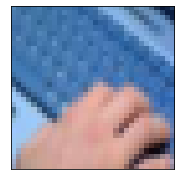

In [15]:
plt.figure(figsize=(6,3))
plt.xticks([])
plt.yticks([])
plt.imshow(train_images[10])

In [16]:
test_images = test_images.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
test_images = tf.cast(test_images, tf.float32)
test_images.shape
test_images = test_images/255

In [17]:
# Now we build the labels and images as lists
train_labels = train[b'fine_labels']
test_labels = test[b'fine_labels']

In [19]:
len(train_labels), len(test_labels)

(50000, 10000)

In [20]:
num_ways = [5, 5, 12, 12, 15]
num_shots = [5, 1, 5, 1, 3]
learning_rate = 0.001
img_width = 32
img_height = 32
channels = 3
learning_rate = 0.001
num_classes = 100

In [21]:
print(test_images.shape)
print(train_images.shape)

(10000, 32, 32, 3)
(50000, 32, 32, 3)


In [22]:
#split train into train and val
train_images_split = np.zeros([40000, img_width , img_height, channels], dtype=np.float32)
val_images_split = np.zeros([10000, img_width , img_height, channels], dtype=np.float32)
train_labels_split = np.zeros(40000)
val_labels_split = np.zeros(10000)

train_split = 400
val_split = 100
for class_ in range(len(Classes)):
  train_start_index = class_ * 500
  train_end_index = train_start_index + train_split
  train_index = class_ * train_split
  val_start_index = train_end_index
  val_end_index = val_start_index + val_split
  val_index = class_ * val_split

  train_images_split[train_index : train_index + train_split] = train_images[train_start_index: train_end_index]
  val_images_split[val_index : val_index + val_split] = train_images[val_start_index : val_end_index]


  train_labels_split[train_index : train_index + train_split] = train_labels[train_start_index : train_end_index]
  val_labels_split[val_index : val_index + val_split] = train_labels[val_start_index : val_end_index]


In [24]:
print(test_images.shape)
print(train_images_split.shape)
print(val_images_split.shape)

(10000, 32, 32, 3)
(40000, 32, 32, 3)
(10000, 32, 32, 3)


In [25]:
def get_next_batch(dataset, labels, num_way, num_shot, num_query, no_of_classes):
  episodic_classes = np.random.permutation(no_of_classes)[:num_way]
  support = np.zeros([num_way, num_shot, img_width , img_height, channels], dtype=np.float32)
  query = np.zeros([num_way, num_query, img_width , img_height, channels], dtype=np.float32)

  for index, class_ in enumerate(episodic_classes):
    indices = find_indices(labels, class_)
    #check that the size is greater than num_shot + num_query
    selected = np.random.permutation(indices)[:num_shot + num_query]
    for support_index in range(num_shot):
       support[index][support_index] = dataset[selected[support_index]] 
    for query_index in range(num_query):
       query[index][query_index] = dataset[selected[num_shot + query_index]]  
    
  return support, query

def find_indices(list_to_check, item_to_find):
  indices = []
  for idx, value in enumerate(list_to_check):
    if value == item_to_find:
      indices.append(idx)
  return indices



In [26]:
support, query = get_next_batch(val_images_split, val_labels_split, 20, 7, 3, 100)

In [27]:
support.shape

(20, 7, 32, 32, 3)

In [28]:
query.shape

(20, 3, 32, 32, 3)

In [29]:
def show_image(dataset, index, image_number):
  plt.figure(figsize=(2,3))
  plt.xticks([])
  plt.yticks([])
  plt.imshow(dataset[index][image_number])


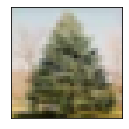

In [30]:
show_image(support, 4, 6)

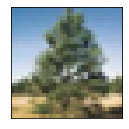

In [31]:
show_image(query, 4, 0)

In [41]:
from tensorflow import keras  
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [42]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Dropout, GlobalMaxPooling2D
from tensorflow.keras import Model

class Prototypical(Model):
    
    def __init__(self, n_support, n_query, w, h, c):
        super(Prototypical, self).__init__()
        self.w, self.h, self.c = w, h, c

        # Encoder as ResNet like CNN with 4 blocks
        self.encoder = keras.Sequential([
            keras.layers.Conv2D(filters=64, kernel_size=3, padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),
            keras.layers.MaxPool2D((2, 2)),

            keras.layers.Conv2D(filters=64, kernel_size=3, padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),
            keras.layers.MaxPool2D((2, 2)),

            keras.layers.Conv2D(filters=64, kernel_size=3, padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),
            keras.layers.MaxPool2D((2, 2)),

            keras.layers.Conv2D(filters=64, kernel_size=3, padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),
            keras.layers.MaxPool2D((2, 2)), Flatten()]
        )

    def call(self, support, query):
        n_class = support.shape[0]
        n_support = support.shape[1]
        n_query = query.shape[1]
        y = np.tile(np.arange(n_class)[:, np.newaxis], (1, n_query))
        y_onehot = tf.cast(tf.one_hot(y, n_class), tf.float32)

        # correct indices of support samples (just natural order)
        target_inds = tf.reshape(tf.range(n_class), [n_class, 1])
        target_inds = tf.tile(target_inds, [1, n_query])

        # merge support and query to forward through encoder
        cat = tf.concat([
            tf.reshape(support, [n_class * n_support,
                                 self.w, self.h, self.c]),
            tf.reshape(query, [n_class * n_query,
                               self.w, self.h, self.c])], axis=0)
        z = self.encoder(cat)

        # Divide embedding into support and query
        z_prototypes = tf.reshape(z[:n_class * n_support],
                                  [n_class, n_support, z.shape[-1]])
        # Prototypes are means of n_support examples
        z_prototypes = tf.math.reduce_mean(z_prototypes, axis=1)
        z_query = z[n_class * n_support:]

        # Calculate distances between query and prototypes
        dists = euclidean_distance(z_query, z_prototypes)

        # log softmax of calculated distances
        log_p_y = tf.nn.log_softmax(-dists, axis=-1)
        log_p_y = tf.reshape(log_p_y, [n_class, n_query, -1])
        
        loss = -tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_onehot, log_p_y), axis=-1), [-1]))
        eq = tf.cast(tf.equal(
            tf.cast(tf.argmax(log_p_y, axis=-1), tf.int32), 
            tf.cast(y, tf.int32)), tf.float32)
        acc = tf.reduce_mean(eq)
        return loss, acc

    def save(self, model_path):
        self.encoder.save(model_path)

    def load(self, model_path):
        self.encoder(tf.zeros([1, self.w, self.h, self.c]))
        self.encoder.load_weights(model_path)

In [34]:
def euclidean_distance(a, b):

    N, D = tf.shape(a)[0], tf.shape(a)[1]
    M = tf.shape(b)[0]
    a = tf.tile(tf.expand_dims(a, axis=1), (1, M, 1))
    b = tf.tile(tf.expand_dims(b, axis=0), (N, 1, 1))
    return tf.reduce_mean(tf.square(a - b), axis=2)

In [35]:
#number of classes
num_way = num_ways[0] 

#number of examples per class for support set
num_shot = num_shots[0]  

#number of query points
num_query = num_shots[0] 

train_loss = tf.metrics.Mean(name='train_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer = tf.keras.optimizers.Adam(learning_rate)

num_epochs = 80
num_episodes = 100
save_path = "./results/models/cifar100_train0.h5"

least_loss = {'least_loss': 100.00}

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  train_loss(loss)
  train_acc(acc)

@tf.function
def val_step(loss_func, support, query):
  loss, acc = loss_func(support, query)
  val_loss(loss)
  val_acc(acc)

for epoch in range(num_epochs):
  train_loss.reset_states()
  train_acc.reset_states()

  for episode in range(num_episodes):
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)
    train_step(train_support, train_query)

  cur_loss = train_loss.result().numpy()
  if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)
      
  template = 'Epoch {}, Loss: {}, Accuracy: {}'
  print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100))

Saving new best model with loss:  1.5534722
Epoch 1, Loss: 1.5534721612930298, Accuracy: 33.320003509521484


Saving new best model with loss:  1.3736037
Epoch 2, Loss: 1.3736037015914917, Accuracy: 43.52000427246094


Saving new best model with loss:  1.3290579
Epoch 3, Loss: 1.3290579319000244, Accuracy: 45.52000045776367
Epoch 4, Loss: 1.3447411060333252, Accuracy: 44.000003814697266


Saving new best model with loss:  1.296051
Epoch 5, Loss: 1.296051025390625, Accuracy: 47.72000503540039
Epoch 6, Loss: 1.3193376064300537, Accuracy: 45.76000213623047


Saving new best model with loss:  1.295448
Epoch 7, Loss: 1.2954479455947876, Accuracy: 47.4000129699707


Saving new best model with loss:  1.2816093
Epoch 8, Loss: 1.281609296798706, Accuracy: 47.07999801635742


Saving new best model with loss:  1.2366254
Epoch 9, Loss: 1.2366254329681396, Accuracy: 48.239990234375


Saving new best model with loss:  1.2277669
Epoch 10, Loss: 1.2277668714523315, Accuracy: 50.639991760253906


Saving new best model with loss:  1.2266313
Epoch 11, Loss: 1.2266312837600708, Accuracy: 49.79998779296875
Epoch 12, Loss: 1.2507644891738892, Accuracy: 50.96000289916992


Saving new best model with loss:  1.1930882
Epoch 13, Loss: 1.193088173866272, Accuracy: 51.279998779296875
Epoch 14, Loss: 1.2376160621643066, Accuracy: 49.399993896484375
Epoch 15, Loss: 1.2153370380401611, Accuracy: 51.519989013671875


Saving new best model with loss:  1.1844034
Epoch 16, Loss: 1.184403419494629, Accuracy: 52.43999481201172


Saving new best model with loss:  1.1769506
Epoch 17, Loss: 1.1769505739212036, Accuracy: 53.07999801635742
Epoch 18, Loss: 1.177234172821045, Accuracy: 53.43999099731445
Epoch 19, Loss: 1.200439453125, Accuracy: 52.03999710083008


Saving new best model with loss:  1.1586424
Epoch 20, Loss: 1.1586424112319946, Accuracy: 53.480018615722656
Epoch 21, Loss: 1.1748119592666626, Accuracy: 53.03998565673828
Epoch 22, Loss: 1.1652559041976929, Accuracy: 54.000003814697266


Saving new best model with loss:  1.1518946
Epoch 23, Loss: 1.1518945693969727, Accuracy: 53.84001159667969


Saving new best model with loss:  1.1215864
Epoch 24, Loss: 1.1215864419937134, Accuracy: 54.720001220703125
Epoch 25, Loss: 1.1349461078643799, Accuracy: 54.71998596191406
Epoch 26, Loss: 1.1492282152175903, Accuracy: 55.64000701904297


Saving new best model with loss:  1.0518594
Epoch 27, Loss: 1.0518593788146973, Accuracy: 58.079994201660156
Epoch 28, Loss: 1.1573928594589233, Accuracy: 52.95999526977539
Epoch 29, Loss: 1.05605947971344, Accuracy: 58.440006256103516
Epoch 30, Loss: 1.0930061340332031, Accuracy: 56.31999206542969
Epoch 31, Loss: 1.0836060047149658, Accuracy: 55.519996643066406
Epoch 32, Loss: 1.1142264604568481, Accuracy: 53.920005798339844
Epoch 33, Loss: 1.0534673929214478, Accuracy: 57.60000228881836
Epoch 34, Loss: 1.065067172050476, Accuracy: 57.5999870300293
Epoch 35, Loss: 1.078088402748108, Accuracy: 57.04001235961914
Epoch 36, Loss: 1.0923267602920532, Accuracy: 56.480003356933594


Saving new best model with loss:  1.0471588
Epoch 37, Loss: 1.0471588373184204, Accuracy: 58.16000747680664


Saving new best model with loss:  1.0104426
Epoch 38, Loss: 1.0104426145553589, Accuracy: 60.160003662109375


Saving new best model with loss:  0.9983528
Epoch 39, Loss: 0.9983528256416321, Accuracy: 60.880001068115234
Epoch 40, Loss: 1.046949863433838, Accuracy: 59.16000747680664


Saving new best model with loss:  0.9814155
Epoch 41, Loss: 0.9814155101776123, Accuracy: 61.43998336791992
Epoch 42, Loss: 0.9826287031173706, Accuracy: 61.27998352050781
Epoch 43, Loss: 1.0237215757369995, Accuracy: 59.31999206542969
Epoch 44, Loss: 1.0517634153366089, Accuracy: 58.52000045776367
Epoch 45, Loss: 0.9924248456954956, Accuracy: 60.60000228881836
Epoch 46, Loss: 1.0110911130905151, Accuracy: 59.92000198364258
Epoch 47, Loss: 0.9968621730804443, Accuracy: 60.24000549316406


Saving new best model with loss:  0.9484034
Epoch 48, Loss: 0.9484034180641174, Accuracy: 62.12000274658203
Epoch 49, Loss: 0.9891582727432251, Accuracy: 62.27998733520508
Epoch 50, Loss: 1.026911735534668, Accuracy: 59.239994049072266
Epoch 51, Loss: 1.0124149322509766, Accuracy: 58.55998229980469
Epoch 52, Loss: 0.9873693585395813, Accuracy: 60.999996185302734
Epoch 53, Loss: 0.9524909853935242, Accuracy: 62.519996643066406
Epoch 54, Loss: 0.9566190242767334, Accuracy: 61.760009765625
Epoch 55, Loss: 0.9961177706718445, Accuracy: 60.3599967956543
Epoch 56, Loss: 0.9704766869544983, Accuracy: 62.23999786376953
Epoch 57, Loss: 0.95377516746521, Accuracy: 62.87997817993164


Saving new best model with loss:  0.9304436
Epoch 58, Loss: 0.9304435849189758, Accuracy: 62.87997817993164


Saving new best model with loss:  0.92135435
Epoch 59, Loss: 0.921354353427887, Accuracy: 65.12001037597656
Epoch 60, Loss: 0.9868370294570923, Accuracy: 60.27999496459961
Epoch 61, Loss: 0.9685676097869873, Accuracy: 61.91999435424805


Saving new best model with loss:  0.91445374
Epoch 62, Loss: 0.9144537448883057, Accuracy: 64.239990234375


Saving new best model with loss:  0.8870556
Epoch 63, Loss: 0.8870555758476257, Accuracy: 65.04000091552734
Epoch 64, Loss: 0.9200125336647034, Accuracy: 64.03999328613281
Epoch 65, Loss: 0.9240662455558777, Accuracy: 64.19999694824219
Epoch 66, Loss: 0.9233133792877197, Accuracy: 64.07999420166016


Saving new best model with loss:  0.8765032
Epoch 67, Loss: 0.8765032291412354, Accuracy: 66.03999328613281
Epoch 68, Loss: 0.9317643046379089, Accuracy: 62.400001525878906


Saving new best model with loss:  0.86398214
Epoch 69, Loss: 0.8639821410179138, Accuracy: 66.51998138427734


Saving new best model with loss:  0.82423866
Epoch 70, Loss: 0.824238657951355, Accuracy: 65.87998962402344
Epoch 71, Loss: 0.9427096843719482, Accuracy: 62.35999298095703
Epoch 72, Loss: 0.8492876291275024, Accuracy: 68.07999420166016
Epoch 73, Loss: 0.9019239544868469, Accuracy: 63.31999206542969
Epoch 74, Loss: 0.9079892039299011, Accuracy: 64.3599853515625
Epoch 75, Loss: 0.8947383761405945, Accuracy: 64.79999542236328
Epoch 76, Loss: 0.8815118670463562, Accuracy: 65.87999725341797
Epoch 77, Loss: 0.8734992742538452, Accuracy: 66.36000061035156
Epoch 78, Loss: 0.8324078321456909, Accuracy: 65.87999725341797


Saving new best model with loss:  0.78943884
Epoch 79, Loss: 0.7894388437271118, Accuracy: 70.23998260498047
Epoch 80, Loss: 0.8621929883956909, Accuracy: 66.35997772216797


In [59]:
#number of classes
num_way = num_ways[1] 

#number of examples per class for support set
num_shot = num_shots[1]  

#number of query points
num_query = num_shots[1] 

train_loss = tf.metrics.Mean(name='train_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer = tf.keras.optimizers.Adam(learning_rate)

num_epochs = 80
num_episodes = 100
save_path = "./results/models/cifar100_train1.h5"

least_loss = {'least_loss': 100.00}

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  train_loss(loss)
  train_acc(acc)

@tf.function
def val_step(loss_func, support, query):
  loss, acc = loss_func(support, query)
  val_loss(loss)
  val_acc(acc)

val_losses = []

for epoch in range(num_epochs):
  train_loss.reset_states()
  train_acc.reset_states()

  for episode in range(num_episodes):
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)
    train_step(train_support, train_query)

  cur_loss = train_loss.result().numpy()
  if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)
      
  template = 'Epoch {}, Loss: {}, Accuracy: {}'
  print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100))

Saving new best model with loss:  1.598916
Epoch 1, Loss: 1.5989160537719727, Accuracy: 28.0


Saving new best model with loss:  1.5852009
Epoch 2, Loss: 1.5852009057998657, Accuracy: 31.599998474121094


Saving new best model with loss:  1.5817511
Epoch 3, Loss: 1.5817511081695557, Accuracy: 29.800003051757812
Epoch 4, Loss: 1.6080043315887451, Accuracy: 27.000003814697266
Epoch 5, Loss: 1.5823051929473877, Accuracy: 33.000003814697266


Saving new best model with loss:  1.578149
Epoch 6, Loss: 1.5781489610671997, Accuracy: 28.800004959106445


Saving new best model with loss:  1.5643615
Epoch 7, Loss: 1.5643614530563354, Accuracy: 31.60000228881836
Epoch 8, Loss: 1.567354440689087, Accuracy: 30.599998474121094


Saving new best model with loss:  1.5524806
Epoch 9, Loss: 1.5524805784225464, Accuracy: 31.20000457763672


Saving new best model with loss:  1.5378116
Epoch 10, Loss: 1.5378116369247437, Accuracy: 32.40000915527344


Saving new best model with loss:  1.5129989
Epoch 11, Loss: 1.5129989385604858, Accuracy: 37.200008392333984


Saving new best model with loss:  1.4889468
Epoch 12, Loss: 1.488946795463562, Accuracy: 35.60001754760742


Saving new best model with loss:  1.4708084
Epoch 13, Loss: 1.4708083868026733, Accuracy: 34.800010681152344
Epoch 14, Loss: 1.5144222974777222, Accuracy: 34.40000915527344
Epoch 15, Loss: 1.5228052139282227, Accuracy: 35.400001525878906
Epoch 16, Loss: 1.5382018089294434, Accuracy: 33.599998474121094
Epoch 17, Loss: 1.5330047607421875, Accuracy: 34.80001449584961
Epoch 18, Loss: 1.5190494060516357, Accuracy: 34.600006103515625
Epoch 19, Loss: 1.5005602836608887, Accuracy: 36.399993896484375
Epoch 20, Loss: 1.5344680547714233, Accuracy: 31.000011444091797
Epoch 21, Loss: 1.5078816413879395, Accuracy: 33.200008392333984
Epoch 22, Loss: 1.506223440170288, Accuracy: 35.4000129699707
Epoch 23, Loss: 1.5174740552902222, Accuracy: 32.400001525878906
Epoch 24, Loss: 1.5020012855529785, Accuracy: 34.4000129699707
Epoch 25, Loss: 1.5024951696395874, Accuracy: 34.600013732910156


Saving new best model with loss:  1.4423027
Epoch 26, Loss: 1.4423027038574219, Accuracy: 38.600006103515625
Epoch 27, Loss: 1.4931401014328003, Accuracy: 35.4000129699707
Epoch 28, Loss: 1.4908032417297363, Accuracy: 38.000003814697266
Epoch 29, Loss: 1.4961658716201782, Accuracy: 33.60000228881836
Epoch 30, Loss: 1.5339508056640625, Accuracy: 31.400007247924805
Epoch 31, Loss: 1.4967679977416992, Accuracy: 31.80000114440918
Epoch 32, Loss: 1.4739861488342285, Accuracy: 36.60000228881836
Epoch 33, Loss: 1.5188522338867188, Accuracy: 32.600006103515625
Epoch 34, Loss: 1.4496883153915405, Accuracy: 36.599998474121094
Epoch 35, Loss: 1.4943565130233765, Accuracy: 34.000003814697266
Epoch 36, Loss: 1.4980080127716064, Accuracy: 38.400001525878906
Epoch 37, Loss: 1.485076904296875, Accuracy: 34.80000686645508
Epoch 38, Loss: 1.4494316577911377, Accuracy: 37.0
Epoch 39, Loss: 1.4912165403366089, Accuracy: 38.60001754760742
Epoch 40, Loss: 1.4760830402374268, Accuracy: 34.600006103515625
Epo

Saving new best model with loss:  1.4130962
Epoch 44, Loss: 1.4130961894989014, Accuracy: 38.4000129699707
Epoch 45, Loss: 1.4841710329055786, Accuracy: 34.80000305175781
Epoch 46, Loss: 1.485864520072937, Accuracy: 33.20000076293945
Epoch 47, Loss: 1.4857975244522095, Accuracy: 34.20000457763672
Epoch 48, Loss: 1.45671808719635, Accuracy: 36.40001678466797
Epoch 49, Loss: 1.4691966772079468, Accuracy: 37.20000457763672
Epoch 50, Loss: 1.4732794761657715, Accuracy: 39.60001754760742
Epoch 51, Loss: 1.4814844131469727, Accuracy: 35.40000534057617
Epoch 52, Loss: 1.5034397840499878, Accuracy: 32.600006103515625
Epoch 53, Loss: 1.4641908407211304, Accuracy: 37.4000129699707
Epoch 54, Loss: 1.4842182397842407, Accuracy: 38.400001525878906
Epoch 55, Loss: 1.4482346773147583, Accuracy: 39.4000129699707
Epoch 56, Loss: 1.4758487939834595, Accuracy: 32.200008392333984
Epoch 57, Loss: 1.4445216655731201, Accuracy: 38.60000991821289
Epoch 58, Loss: 1.4472090005874634, Accuracy: 36.0
Epoch 59, Lo

Saving new best model with loss:  1.4085362
Epoch 72, Loss: 1.4085361957550049, Accuracy: 39.600013732910156
Epoch 73, Loss: 1.4249298572540283, Accuracy: 39.60000991821289


Saving new best model with loss:  1.3959558
Epoch 74, Loss: 1.3959558010101318, Accuracy: 40.60000991821289


Saving new best model with loss:  1.3678391
Epoch 75, Loss: 1.3678390979766846, Accuracy: 42.00000762939453
Epoch 76, Loss: 1.4662060737609863, Accuracy: 38.00000762939453
Epoch 77, Loss: 1.4575107097625732, Accuracy: 35.20000457763672
Epoch 78, Loss: 1.4110838174819946, Accuracy: 41.20000457763672
Epoch 79, Loss: 1.4066166877746582, Accuracy: 39.800018310546875
Epoch 80, Loss: 1.4306819438934326, Accuracy: 41.80000686645508


In [60]:
#number of classes
num_way = num_ways[2] 

#number of examples per class for support set
num_shot = num_shots[2]  

#number of query points
num_query = num_shots[2] 

train_loss = tf.metrics.Mean(name='train_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer = tf.keras.optimizers.Adam(learning_rate)

num_epochs = 80
num_episodes = 100
save_path = "./results/models/cifar100_train2.h5"

least_loss = {'least_loss': 100.00}

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  train_loss(loss)
  train_acc(acc)

@tf.function
def val_step(loss_func, support, query):
  loss, acc = loss_func(support, query)
  val_loss(loss)
  val_acc(acc)

val_losses = []

for epoch in range(num_epochs):
  train_loss.reset_states()
  train_acc.reset_states()

  for episode in range(num_episodes):
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)
    train_step(train_support, train_query)

  cur_loss = train_loss.result().numpy()
  if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)
      
  template = 'Epoch {}, Loss: {}, Accuracy: {}'
  print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100))

Saving new best model with loss:  2.3277044
Epoch 1, Loss: 2.327704429626465, Accuracy: 20.883338928222656


Saving new best model with loss:  2.152342
Epoch 2, Loss: 2.1523420810699463, Accuracy: 26.40000343322754


Saving new best model with loss:  2.0893743
Epoch 3, Loss: 2.089374303817749, Accuracy: 28.583335876464844
Epoch 4, Loss: 2.102234363555908, Accuracy: 28.049999237060547


Saving new best model with loss:  2.0182314
Epoch 5, Loss: 2.0182313919067383, Accuracy: 30.583337783813477


Saving new best model with loss:  1.9964443
Epoch 6, Loss: 1.9964443445205688, Accuracy: 32.88333511352539


Saving new best model with loss:  1.9666821
Epoch 7, Loss: 1.9666820764541626, Accuracy: 33.83332824707031


Saving new best model with loss:  1.9399563
Epoch 8, Loss: 1.9399563074111938, Accuracy: 34.15000534057617


Saving new best model with loss:  1.8824562
Epoch 9, Loss: 1.8824561834335327, Accuracy: 36.266658782958984


Saving new best model with loss:  1.8788959
Epoch 10, Loss: 1.878895878791809, Accuracy: 37.166664123535156


Saving new best model with loss:  1.8458785
Epoch 11, Loss: 1.8458784818649292, Accuracy: 38.18333435058594
Epoch 12, Loss: 1.8638414144515991, Accuracy: 37.10000228881836


Saving new best model with loss:  1.8230033
Epoch 13, Loss: 1.8230032920837402, Accuracy: 38.55000305175781


Saving new best model with loss:  1.7893835
Epoch 14, Loss: 1.7893835306167603, Accuracy: 39.41666793823242


Saving new best model with loss:  1.7625352
Epoch 15, Loss: 1.7625352144241333, Accuracy: 40.23332977294922
Epoch 16, Loss: 1.772049903869629, Accuracy: 40.79999542236328


Saving new best model with loss:  1.7203424
Epoch 17, Loss: 1.7203423976898193, Accuracy: 42.5333251953125
Epoch 18, Loss: 1.7525224685668945, Accuracy: 40.91667556762695


Saving new best model with loss:  1.6946677
Epoch 19, Loss: 1.6946676969528198, Accuracy: 43.08333969116211


Saving new best model with loss:  1.6802619
Epoch 20, Loss: 1.6802618503570557, Accuracy: 43.56667709350586


Saving new best model with loss:  1.6796029
Epoch 21, Loss: 1.679602861404419, Accuracy: 42.85000228881836


Saving new best model with loss:  1.6546992
Epoch 22, Loss: 1.6546992063522339, Accuracy: 44.95000457763672
Epoch 23, Loss: 1.6568065881729126, Accuracy: 43.9333381652832


Saving new best model with loss:  1.6157924
Epoch 24, Loss: 1.6157923936843872, Accuracy: 45.983333587646484
Epoch 25, Loss: 1.6308842897415161, Accuracy: 44.116661071777344
Epoch 26, Loss: 1.6170508861541748, Accuracy: 44.61667251586914


Saving new best model with loss:  1.6135219
Epoch 27, Loss: 1.613521933555603, Accuracy: 45.63332748413086


Saving new best model with loss:  1.5713981
Epoch 28, Loss: 1.571398138999939, Accuracy: 47.31666946411133


Saving new best model with loss:  1.5572798
Epoch 29, Loss: 1.5572798252105713, Accuracy: 46.84999084472656


Saving new best model with loss:  1.5525081
Epoch 30, Loss: 1.5525081157684326, Accuracy: 47.68333053588867


Saving new best model with loss:  1.5304375
Epoch 31, Loss: 1.5304374694824219, Accuracy: 48.216670989990234
Epoch 32, Loss: 1.5483105182647705, Accuracy: 48.01667022705078


Saving new best model with loss:  1.5263569
Epoch 33, Loss: 1.5263569355010986, Accuracy: 48.733333587646484


Saving new best model with loss:  1.5081154
Epoch 34, Loss: 1.5081154108047485, Accuracy: 49.233333587646484


Saving new best model with loss:  1.4919144
Epoch 35, Loss: 1.4919143915176392, Accuracy: 49.916664123535156
Epoch 36, Loss: 1.5240734815597534, Accuracy: 48.333335876464844


Saving new best model with loss:  1.4603766
Epoch 37, Loss: 1.4603766202926636, Accuracy: 49.94999313354492
Epoch 38, Loss: 1.4795070886611938, Accuracy: 50.016658782958984


Saving new best model with loss:  1.4471436
Epoch 39, Loss: 1.4471435546875, Accuracy: 50.85000228881836


Saving new best model with loss:  1.4027656
Epoch 40, Loss: 1.4027656316757202, Accuracy: 52.16666030883789


Saving new best model with loss:  1.3908925
Epoch 41, Loss: 1.390892505645752, Accuracy: 53.399993896484375


Saving new best model with loss:  1.3759564
Epoch 42, Loss: 1.375956416130066, Accuracy: 52.90000534057617
Epoch 43, Loss: 1.4393521547317505, Accuracy: 51.650001525878906
Epoch 44, Loss: 1.4002403020858765, Accuracy: 52.28331756591797


Saving new best model with loss:  1.3481842
Epoch 45, Loss: 1.3481842279434204, Accuracy: 53.95000457763672
Epoch 46, Loss: 1.3798695802688599, Accuracy: 53.40001678466797


Saving new best model with loss:  1.3233036
Epoch 47, Loss: 1.3233035802841187, Accuracy: 55.166656494140625
Epoch 48, Loss: 1.3252159357070923, Accuracy: 54.75


Saving new best model with loss:  1.305137
Epoch 49, Loss: 1.305137038230896, Accuracy: 56.20000457763672
Epoch 50, Loss: 1.3064602613449097, Accuracy: 55.0000114440918


Saving new best model with loss:  1.2982035
Epoch 51, Loss: 1.298203468322754, Accuracy: 55.68333435058594


Saving new best model with loss:  1.2743834
Epoch 52, Loss: 1.2743834257125854, Accuracy: 57.16666030883789
Epoch 53, Loss: 1.3456718921661377, Accuracy: 53.933326721191406
Epoch 54, Loss: 1.3096193075180054, Accuracy: 55.78333282470703
Epoch 55, Loss: 1.2754743099212646, Accuracy: 56.49998092651367
Epoch 56, Loss: 1.2817851305007935, Accuracy: 55.733333587646484


Saving new best model with loss:  1.2550056
Epoch 57, Loss: 1.2550055980682373, Accuracy: 56.966651916503906
Epoch 58, Loss: 1.2605559825897217, Accuracy: 56.483314514160156
Epoch 59, Loss: 1.2754523754119873, Accuracy: 57.266658782958984


Saving new best model with loss:  1.219772
Epoch 60, Loss: 1.2197719812393188, Accuracy: 58.26666259765625
Epoch 61, Loss: 1.2701457738876343, Accuracy: 55.99999237060547
Epoch 62, Loss: 1.2615886926651, Accuracy: 56.633323669433594
Epoch 63, Loss: 1.2476028203964233, Accuracy: 56.94999694824219
Epoch 64, Loss: 1.2580047845840454, Accuracy: 56.533329010009766
Epoch 65, Loss: 1.246607780456543, Accuracy: 57.36664962768555
Epoch 66, Loss: 1.2305424213409424, Accuracy: 57.44998550415039


Saving new best model with loss:  1.1972601
Epoch 67, Loss: 1.1972601413726807, Accuracy: 58.60000991821289
Epoch 68, Loss: 1.2059634923934937, Accuracy: 59.21666717529297


Saving new best model with loss:  1.1908773
Epoch 69, Loss: 1.1908773183822632, Accuracy: 58.79999542236328


Saving new best model with loss:  1.1791428
Epoch 70, Loss: 1.1791428327560425, Accuracy: 60.11668014526367
Epoch 71, Loss: 1.1947600841522217, Accuracy: 58.61664962768555


Saving new best model with loss:  1.1332852
Epoch 72, Loss: 1.1332851648330688, Accuracy: 61.050010681152344
Epoch 73, Loss: 1.1652140617370605, Accuracy: 60.216651916503906
Epoch 74, Loss: 1.1521779298782349, Accuracy: 60.93332290649414
Epoch 75, Loss: 1.167134404182434, Accuracy: 59.88331985473633
Epoch 76, Loss: 1.1885230541229248, Accuracy: 59.916656494140625
Epoch 77, Loss: 1.153279423713684, Accuracy: 60.41667938232422
Epoch 78, Loss: 1.1342445611953735, Accuracy: 61.23333740234375
Epoch 79, Loss: 1.1386643648147583, Accuracy: 60.650001525878906
Epoch 80, Loss: 1.1347731351852417, Accuracy: 60.9333381652832


In [61]:
#number of classes
num_way = num_ways[3] 

#number of examples per class for support set
num_shot = num_shots[3]  

#number of query points
num_query = num_shots[3] 

train_loss = tf.metrics.Mean(name='train_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer = tf.keras.optimizers.Adam(learning_rate)

num_epochs = 80
num_episodes = 100
save_path = "./results/models/cifar100_train3.h5"

least_loss = {'least_loss': 100.00}

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  train_loss(loss)
  train_acc(acc)

@tf.function
def val_step(loss_func, support, query):
  loss, acc = loss_func(support, query)
  val_loss(loss)
  val_acc(acc)

val_losses = []

for epoch in range(num_epochs):
  train_loss.reset_states()
  train_acc.reset_states()

  for episode in range(num_episodes):
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)
    train_step(train_support, train_query)

  cur_loss = train_loss.result().numpy()
  if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)
      
  template = 'Epoch {}, Loss: {}, Accuracy: {}'
  print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100))

Saving new best model with loss:  2.4430752
Epoch 1, Loss: 2.443075180053711, Accuracy: 16.75


Saving new best model with loss:  2.399337
Epoch 2, Loss: 2.39933705329895, Accuracy: 17.750001907348633


Saving new best model with loss:  2.3720853
Epoch 3, Loss: 2.3720853328704834, Accuracy: 16.916664123535156
Epoch 4, Loss: 2.388019323348999, Accuracy: 16.750001907348633


Saving new best model with loss:  2.3578427
Epoch 5, Loss: 2.3578426837921143, Accuracy: 19.333330154418945
Epoch 6, Loss: 2.3625190258026123, Accuracy: 16.66666603088379
Epoch 7, Loss: 2.38893985748291, Accuracy: 18.75
Epoch 8, Loss: 2.372443437576294, Accuracy: 20.25


Saving new best model with loss:  2.3378482
Epoch 9, Loss: 2.33784818649292, Accuracy: 19.750001907348633
Epoch 10, Loss: 2.3727235794067383, Accuracy: 17.33333396911621
Epoch 11, Loss: 2.361941337585449, Accuracy: 19.25


Saving new best model with loss:  2.300271
Epoch 12, Loss: 2.3002710342407227, Accuracy: 20.166667938232422
Epoch 13, Loss: 2.314343214035034, Accuracy: 18.833335876464844


Saving new best model with loss:  2.297554
Epoch 14, Loss: 2.2975540161132812, Accuracy: 21.500003814697266
Epoch 15, Loss: 2.3280370235443115, Accuracy: 20.249998092651367
Epoch 16, Loss: 2.3339643478393555, Accuracy: 20.583328247070312
Epoch 17, Loss: 2.332725763320923, Accuracy: 20.0
Epoch 18, Loss: 2.3052661418914795, Accuracy: 20.33333396911621
Epoch 19, Loss: 2.3255155086517334, Accuracy: 20.999996185302734
Epoch 20, Loss: 2.300858497619629, Accuracy: 21.41666603088379
Epoch 21, Loss: 2.303891658782959, Accuracy: 21.750003814697266
Epoch 22, Loss: 2.3146378993988037, Accuracy: 18.666667938232422
Epoch 23, Loss: 2.3294191360473633, Accuracy: 20.333335876464844


Saving new best model with loss:  2.2911184
Epoch 24, Loss: 2.2911183834075928, Accuracy: 21.416669845581055


Saving new best model with loss:  2.2754893
Epoch 25, Loss: 2.275489330291748, Accuracy: 22.666669845581055


Saving new best model with loss:  2.2590635
Epoch 26, Loss: 2.259063482284546, Accuracy: 22.666669845581055
Epoch 27, Loss: 2.2786121368408203, Accuracy: 20.33333396911621


Saving new best model with loss:  2.2521098
Epoch 28, Loss: 2.2521097660064697, Accuracy: 22.916667938232422
Epoch 29, Loss: 2.304133653640747, Accuracy: 22.166667938232422


Saving new best model with loss:  2.2439187
Epoch 30, Loss: 2.2439186573028564, Accuracy: 23.999990463256836
Epoch 31, Loss: 2.2773425579071045, Accuracy: 20.66666603088379
Epoch 32, Loss: 2.27547550201416, Accuracy: 22.249996185302734
Epoch 33, Loss: 2.268187999725342, Accuracy: 22.166662216186523
Epoch 34, Loss: 2.2604734897613525, Accuracy: 22.666664123535156
Epoch 35, Loss: 2.2528507709503174, Accuracy: 23.916669845581055


Saving new best model with loss:  2.2232258
Epoch 36, Loss: 2.2232258319854736, Accuracy: 24.750001907348633
Epoch 37, Loss: 2.23514986038208, Accuracy: 22.166664123535156
Epoch 38, Loss: 2.2445459365844727, Accuracy: 21.16666603088379
Epoch 39, Loss: 2.2347967624664307, Accuracy: 23.083335876464844
Epoch 40, Loss: 2.2451207637786865, Accuracy: 22.583332061767578
Epoch 41, Loss: 2.2392477989196777, Accuracy: 22.91666603088379
Epoch 42, Loss: 2.243637800216675, Accuracy: 23.0
Epoch 43, Loss: 2.2612874507904053, Accuracy: 21.166667938232422


Saving new best model with loss:  2.2041855
Epoch 44, Loss: 2.2041854858398438, Accuracy: 25.833332061767578
Epoch 45, Loss: 2.2208847999572754, Accuracy: 23.916667938232422
Epoch 46, Loss: 2.241102695465088, Accuracy: 23.000003814697266
Epoch 47, Loss: 2.223487377166748, Accuracy: 25.000003814697266


Saving new best model with loss:  2.2036538
Epoch 48, Loss: 2.2036538124084473, Accuracy: 24.58333396911621


Saving new best model with loss:  2.1926818
Epoch 49, Loss: 2.1926817893981934, Accuracy: 25.416664123535156
Epoch 50, Loss: 2.195246934890747, Accuracy: 25.916667938232422
Epoch 51, Loss: 2.193237543106079, Accuracy: 25.250001907348633
Epoch 52, Loss: 2.200535774230957, Accuracy: 25.333332061767578
Epoch 53, Loss: 2.2285356521606445, Accuracy: 22.916671752929688


Saving new best model with loss:  2.187284
Epoch 54, Loss: 2.187283992767334, Accuracy: 24.416664123535156


Saving new best model with loss:  2.1668365
Epoch 55, Loss: 2.1668365001678467, Accuracy: 24.416662216186523
Epoch 56, Loss: 2.1974921226501465, Accuracy: 24.083328247070312
Epoch 57, Loss: 2.1767382621765137, Accuracy: 26.666667938232422
Epoch 58, Loss: 2.1995739936828613, Accuracy: 25.333332061767578
Epoch 59, Loss: 2.169046401977539, Accuracy: 26.16666603088379


Saving new best model with loss:  2.1498933
Epoch 60, Loss: 2.149893283843994, Accuracy: 26.750001907348633
Epoch 61, Loss: 2.1568217277526855, Accuracy: 27.00000762939453


Saving new best model with loss:  2.143735
Epoch 62, Loss: 2.143734931945801, Accuracy: 28.0000057220459
Epoch 63, Loss: 2.1495184898376465, Accuracy: 27.749998092651367


Saving new best model with loss:  2.130308
Epoch 64, Loss: 2.130307912826538, Accuracy: 29.083330154418945
Epoch 65, Loss: 2.133465051651001, Accuracy: 27.33333396911621
Epoch 66, Loss: 2.151970863342285, Accuracy: 27.000001907348633


Saving new best model with loss:  2.1080394
Epoch 67, Loss: 2.108039379119873, Accuracy: 26.833337783813477
Epoch 68, Loss: 2.123612403869629, Accuracy: 25.416669845581055
Epoch 69, Loss: 2.1323413848876953, Accuracy: 27.83333969116211


Saving new best model with loss:  2.0854545
Epoch 70, Loss: 2.0854544639587402, Accuracy: 28.0000057220459
Epoch 71, Loss: 2.150845766067505, Accuracy: 26.499998092651367


Saving new best model with loss:  2.0851588
Epoch 72, Loss: 2.0851588249206543, Accuracy: 27.999996185302734
Epoch 73, Loss: 2.1455488204956055, Accuracy: 26.833328247070312
Epoch 74, Loss: 2.115501642227173, Accuracy: 25.833330154418945
Epoch 75, Loss: 2.1307871341705322, Accuracy: 25.916667938232422
Epoch 76, Loss: 2.121365785598755, Accuracy: 26.916667938232422
Epoch 77, Loss: 2.085852861404419, Accuracy: 27.916669845581055
Epoch 78, Loss: 2.10559344291687, Accuracy: 27.999996185302734


Saving new best model with loss:  2.0762696
Epoch 79, Loss: 2.0762696266174316, Accuracy: 29.41667366027832


Saving new best model with loss:  2.070484
Epoch 80, Loss: 2.070483922958374, Accuracy: 31.08333396911621


In [62]:
#number of classes
num_way = num_ways[4] 

#number of examples per class for support set
num_shot = num_shots[4]  

#number of query points
num_query = num_shots[4] 

train_loss = tf.metrics.Mean(name='train_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer = tf.keras.optimizers.Adam(learning_rate)

num_epochs = 80
num_episodes = 100
save_path = "./results/models/cifar100_train4.h5"

least_loss = {'least_loss': 100.00}

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  train_loss(loss)
  train_acc(acc)

@tf.function
def val_step(loss_func, support, query):
  loss, acc = loss_func(support, query)
  val_loss(loss)
  val_acc(acc)

val_losses = []

for epoch in range(num_epochs):
  train_loss.reset_states()
  train_acc.reset_states()

  for episode in range(num_episodes):
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)
    train_step(train_support, train_query)

  cur_loss = train_loss.result().numpy()
  if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)
      
  template = 'Epoch {}, Loss: {}, Accuracy: {}'
  print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100))

Saving new best model with loss:  2.577684
Epoch 1, Loss: 2.577683925628662, Accuracy: 18.51111602783203


Saving new best model with loss:  2.415197
Epoch 2, Loss: 2.4151968955993652, Accuracy: 22.066675186157227


Saving new best model with loss:  2.3830984
Epoch 3, Loss: 2.3830983638763428, Accuracy: 23.155553817749023


Saving new best model with loss:  2.3598247
Epoch 4, Loss: 2.3598246574401855, Accuracy: 23.822221755981445


Saving new best model with loss:  2.3494563
Epoch 5, Loss: 2.349456310272217, Accuracy: 24.577783584594727


Saving new best model with loss:  2.2835336
Epoch 6, Loss: 2.2835335731506348, Accuracy: 26.53333282470703


Saving new best model with loss:  2.2620926
Epoch 7, Loss: 2.2620925903320312, Accuracy: 26.711118698120117


Saving new best model with loss:  2.226636
Epoch 8, Loss: 2.2266359329223633, Accuracy: 27.600006103515625


Saving new best model with loss:  2.1874912
Epoch 9, Loss: 2.1874911785125732, Accuracy: 29.0000057220459


Saving new best model with loss:  2.1567636
Epoch 10, Loss: 2.1567635536193848, Accuracy: 30.533340454101562
Epoch 11, Loss: 2.2123827934265137, Accuracy: 28.68889045715332


Saving new best model with loss:  2.1444788
Epoch 12, Loss: 2.1444787979125977, Accuracy: 31.066665649414062


Saving new best model with loss:  2.125417
Epoch 13, Loss: 2.1254169940948486, Accuracy: 31.022226333618164
Epoch 14, Loss: 2.169867753982544, Accuracy: 30.200000762939453
Epoch 15, Loss: 2.1572470664978027, Accuracy: 30.755558013916016


Saving new best model with loss:  2.071491
Epoch 16, Loss: 2.071491003036499, Accuracy: 33.20000457763672
Epoch 17, Loss: 2.079848289489746, Accuracy: 32.46666717529297


Saving new best model with loss:  2.0610602
Epoch 18, Loss: 2.0610601902008057, Accuracy: 33.111114501953125


Saving new best model with loss:  2.0414324
Epoch 19, Loss: 2.0414323806762695, Accuracy: 34.51111602783203


Saving new best model with loss:  2.040805
Epoch 20, Loss: 2.0408051013946533, Accuracy: 33.62223434448242


Saving new best model with loss:  2.0290878
Epoch 21, Loss: 2.029087781906128, Accuracy: 34.488887786865234


Saving new best model with loss:  1.973367
Epoch 22, Loss: 1.9733669757843018, Accuracy: 35.133331298828125
Epoch 23, Loss: 2.033066749572754, Accuracy: 33.91111755371094
Epoch 24, Loss: 2.030095338821411, Accuracy: 34.37778854370117
Epoch 25, Loss: 2.0109148025512695, Accuracy: 35.022220611572266
Epoch 26, Loss: 1.9792178869247437, Accuracy: 35.37777328491211
Epoch 27, Loss: 1.9792355298995972, Accuracy: 35.733341217041016


Saving new best model with loss:  1.942353
Epoch 28, Loss: 1.9423530101776123, Accuracy: 37.04444122314453


Saving new best model with loss:  1.9279337
Epoch 29, Loss: 1.927933692932129, Accuracy: 37.95555114746094


Saving new best model with loss:  1.9217354
Epoch 30, Loss: 1.921735405921936, Accuracy: 36.955543518066406
Epoch 31, Loss: 1.9233492612838745, Accuracy: 37.844444274902344


Saving new best model with loss:  1.920174
Epoch 32, Loss: 1.9201740026474, Accuracy: 36.51112365722656
Epoch 33, Loss: 1.9266990423202515, Accuracy: 38.177772521972656


Saving new best model with loss:  1.8985637
Epoch 34, Loss: 1.8985637426376343, Accuracy: 38.9111213684082


Saving new best model with loss:  1.8901492
Epoch 35, Loss: 1.8901492357254028, Accuracy: 37.28889465332031


Saving new best model with loss:  1.8276126
Epoch 36, Loss: 1.8276126384735107, Accuracy: 41.40000534057617
Epoch 37, Loss: 1.8385341167449951, Accuracy: 40.66667175292969
Epoch 38, Loss: 1.8712807893753052, Accuracy: 39.77778244018555
Epoch 39, Loss: 1.8396127223968506, Accuracy: 39.266666412353516
Epoch 40, Loss: 1.835196852684021, Accuracy: 39.622230529785156
Epoch 41, Loss: 1.841609001159668, Accuracy: 40.155540466308594


Saving new best model with loss:  1.8107872
Epoch 42, Loss: 1.8107872009277344, Accuracy: 40.31111526489258


Saving new best model with loss:  1.7781514
Epoch 43, Loss: 1.7781513929367065, Accuracy: 41.79999542236328
Epoch 44, Loss: 1.7877525091171265, Accuracy: 41.533329010009766
Epoch 45, Loss: 1.7852718830108643, Accuracy: 41.24444580078125


Saving new best model with loss:  1.7765018
Epoch 46, Loss: 1.7765017747879028, Accuracy: 42.4666633605957
Epoch 47, Loss: 1.8009440898895264, Accuracy: 41.11111831665039


Saving new best model with loss:  1.7620605
Epoch 48, Loss: 1.762060523033142, Accuracy: 42.26666259765625


Saving new best model with loss:  1.7481637
Epoch 49, Loss: 1.7481637001037598, Accuracy: 42.60000991821289


Saving new best model with loss:  1.7209764
Epoch 50, Loss: 1.7209763526916504, Accuracy: 43.9333381652832


Saving new best model with loss:  1.6796843
Epoch 51, Loss: 1.6796842813491821, Accuracy: 44.577789306640625
Epoch 52, Loss: 1.7078185081481934, Accuracy: 43.977783203125
Epoch 53, Loss: 1.6839731931686401, Accuracy: 44.60000228881836
Epoch 54, Loss: 1.6836190223693848, Accuracy: 44.53333282470703
Epoch 55, Loss: 1.7169651985168457, Accuracy: 43.28889465332031


Saving new best model with loss:  1.6209385
Epoch 56, Loss: 1.6209385395050049, Accuracy: 46.555564880371094
Epoch 57, Loss: 1.6893141269683838, Accuracy: 44.0
Epoch 58, Loss: 1.6480075120925903, Accuracy: 45.5777702331543
Epoch 59, Loss: 1.6909575462341309, Accuracy: 45.5111083984375
Epoch 60, Loss: 1.6401745080947876, Accuracy: 45.24443817138672


Saving new best model with loss:  1.6045467
Epoch 61, Loss: 1.6045466661453247, Accuracy: 46.57777786254883


Saving new best model with loss:  1.5997967
Epoch 62, Loss: 1.5997966527938843, Accuracy: 48.0000114440918
Epoch 63, Loss: 1.632612705230713, Accuracy: 46.75553894042969
Epoch 64, Loss: 1.6269137859344482, Accuracy: 45.82222366333008


Saving new best model with loss:  1.5956501
Epoch 65, Loss: 1.59565007686615, Accuracy: 47.844451904296875
Epoch 66, Loss: 1.6049013137817383, Accuracy: 46.80000686645508


Saving new best model with loss:  1.5754285
Epoch 67, Loss: 1.5754284858703613, Accuracy: 48.111106872558594
Epoch 68, Loss: 1.5948917865753174, Accuracy: 47.57777786254883
Epoch 69, Loss: 1.600175380706787, Accuracy: 47.377769470214844


Saving new best model with loss:  1.5529767
Epoch 70, Loss: 1.5529767274856567, Accuracy: 48.28888702392578
Epoch 71, Loss: 1.5701156854629517, Accuracy: 48.31111145019531


Saving new best model with loss:  1.5520837
Epoch 72, Loss: 1.5520837306976318, Accuracy: 48.4666748046875


Saving new best model with loss:  1.5294867
Epoch 73, Loss: 1.5294866561889648, Accuracy: 49.68889236450195
Epoch 74, Loss: 1.5636084079742432, Accuracy: 48.20000076293945
Epoch 75, Loss: 1.549952745437622, Accuracy: 47.88890075683594
Epoch 76, Loss: 1.5760912895202637, Accuracy: 48.75555419921875
Epoch 77, Loss: 1.5588434934616089, Accuracy: 48.53333282470703


Saving new best model with loss:  1.5241876
Epoch 78, Loss: 1.5241875648498535, Accuracy: 50.20000457763672


Saving new best model with loss:  1.4927248
Epoch 79, Loss: 1.4927247762680054, Accuracy: 50.488887786865234
Epoch 80, Loss: 1.5349442958831787, Accuracy: 49.200008392333984


In [63]:

model_path = "./results/models/cifar100_train0.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = num_ways[0]

#number of examples per class for support set
num_shot = num_shots[0]  

#number of query points
num_query = num_shots[0] 

#number of examples
num_examples = 100

num_episodes = 1200

support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_examples)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  1.6093625
Accuracy:  35.89663207530975


In [64]:
model_path = "./results/models/cifar100_train1.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = num_ways[1]

#number of examples per class for support set
num_shot = num_shots[1]  

#number of query points
num_query = num_shots[1] 

#number of examples
num_examples = 100

num_episodes = 1200

support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_examples)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  1.6093297
Accuracy:  29.516687989234924


In [65]:
model_path = "./results/models/cifar100_train2.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = num_ways[2]

#number of examples per class for support set
num_shot = num_shots[2]  

#number of query points
num_query = num_shots[2] 

#number of examples
num_examples = 100

num_episodes = 1200

support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_examples)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  2.4847746
Accuracy:  21.73885405063629


In [66]:
model_path = "./results/models/cifar100_train3.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = num_ways[3]

#number of examples per class for support set
num_shot = num_shots[3]  

#number of query points
num_query = num_shots[3] 

#number of examples
num_examples = 100

num_episodes = 1200

support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_examples)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  2.4847887
Accuracy:  15.819448232650757


In [67]:
model_path = "./results/models/cifar100_train4.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = num_ways[4]

#number of examples per class for support set
num_shot = num_shots[4]  

#number of query points
num_query = num_shots[4] 

#number of examples
num_examples = 100

num_episodes = 1200

support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_examples)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  2.7078836
Accuracy:  17.335160076618195


In [49]:
#Now adding reptile to this
meta_step_size = 0.25

#number of classes
num_way = num_ways[0] 

#number of examples per class for support set
num_shot = num_shots[0]  

#number of query points
num_query = num_shots[0] 

#number of examples
num_examples = 100

eval_iters = 20
eval_interval = 4
least_loss = {'least_loss': 100.00}

train_loss = tf.metrics.Mean(name='train_loss')
val_loss = tf.metrics.Mean(name='val_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
val_acc = tf.metrics.Mean(name='val_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer_adam = tf.keras.optimizers.Adam(0.001)
optimizer_sgd = tf.keras.optimizers.SGD(0.001)

num_epochs = 81
num_episodes = 100
save_path = "./results/models/cifar100_train_reptile0.h5"

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  
  train_loss(loss)
  train_acc(acc)
  

@tf.function
def val_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  val_loss(loss)
  val_acc(acc)


least_loss = {'least_loss': 100.00}
for epoch in range(num_epochs):
  train_loss.reset_states()
  val_loss.reset_states()
  train_acc.reset_states()
  val_acc.reset_states()

  for episode in range(num_episodes):
    frac_done = episode / num_episodes
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)
    model = Prototypical(train_support, train_query, img_width, img_height, channels)
    model.call(train_support, train_query)
    old_weights = model.get_weights()
    train_step(train_support, train_query, optimizer_adam)
    new_weights = model.get_weights()

    for part_weight in range(len(new_weights)):
        new_weights[part_weight] = old_weights[part_weight] + (
            (new_weights[part_weight] - old_weights[part_weight]) * cur_meta_step_size
        )

    model.set_weights(new_weights)
    if epoch % eval_interval == 0:
      eval_support, eval_query = get_next_batch(val_images_split, val_labels_split, num_way, num_shot, num_query, num_classes)
      old_vars = model.get_weights()
      val_step(eval_support, eval_query, optimizer_sgd)
      model.set_weights(old_vars)
      
  cur_loss = val_loss.result().numpy()

  if (epoch % eval_interval == 0):
    template = 'Epoch {}, Loss: {}, Accuracy: {}, ' \
                  'Val Loss: {}, Val Accuracy: {}'
    print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100, val_loss.result(),
                            val_acc.result() * 100))
    if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)

  

Epoch 1, Loss: 1.5036752223968506, Accuracy: 37.71999740600586, Val Loss: 1.487634539604187, Val Accuracy: 38.68000411987305
Saving new best model with loss:  1.4876345


Epoch 5, Loss: 1.355270504951477, Accuracy: 44.480003356933594, Val Loss: 1.3263978958129883, Val Accuracy: 44.71999740600586
Saving new best model with loss:  1.3263979


Epoch 9, Loss: 1.2907603979110718, Accuracy: 46.400001525878906, Val Loss: 1.3091789484024048, Val Accuracy: 46.31999588012695
Saving new best model with loss:  1.309179


Epoch 13, Loss: 1.2424434423446655, Accuracy: 49.44001007080078, Val Loss: 1.2612682580947876, Val Accuracy: 51.5999870300293
Saving new best model with loss:  1.2612683


Epoch 17, Loss: 1.158989667892456, Accuracy: 54.040000915527344, Val Loss: 1.1633973121643066, Val Accuracy: 53.480003356933594
Saving new best model with loss:  1.1633973


Epoch 21, Loss: 1.1325095891952515, Accuracy: 55.07999801635742, Val Loss: 1.150446891784668, Val Accuracy: 53.799991607666016
Saving new best model with loss:  1.1504469


Epoch 25, Loss: 1.0792624950408936, Accuracy: 56.720001220703125, Val Loss: 1.1268529891967773, Val Accuracy: 55.91999435424805
Saving new best model with loss:  1.126853


Epoch 29, Loss: 1.031113862991333, Accuracy: 59.159996032714844, Val Loss: 1.1022181510925293, Val Accuracy: 55.799991607666016
Saving new best model with loss:  1.1022182


Epoch 33, Loss: 1.0642895698547363, Accuracy: 55.44001007080078, Val Loss: 1.0951142311096191, Val Accuracy: 56.75999069213867
Saving new best model with loss:  1.0951142


Epoch 37, Loss: 1.0423496961593628, Accuracy: 57.79999923706055, Val Loss: 1.0165902376174927, Val Accuracy: 59.40000534057617
Saving new best model with loss:  1.0165902


Epoch 41, Loss: 0.9918379783630371, Accuracy: 60.9999885559082, Val Loss: 1.0001436471939087, Val Accuracy: 60.07999038696289
Saving new best model with loss:  1.0001436


Epoch 45, Loss: 0.958865761756897, Accuracy: 62.48001480102539, Val Loss: 0.9679837226867676, Val Accuracy: 60.56001281738281
Saving new best model with loss:  0.9679837
Epoch 49, Loss: 0.961426317691803, Accuracy: 62.1199836730957, Val Loss: 0.9905039072036743, Val Accuracy: 59.839988708496094


Epoch 53, Loss: 0.9820749759674072, Accuracy: 60.880001068115234, Val Loss: 0.9453576803207397, Val Accuracy: 61.839996337890625
Saving new best model with loss:  0.9453577
Epoch 57, Loss: 0.9351054430007935, Accuracy: 63.59999084472656, Val Loss: 0.9470184445381165, Val Accuracy: 63.39999008178711
Epoch 61, Loss: 0.9767304062843323, Accuracy: 61.11998748779297, Val Loss: 0.9508388042449951, Val Accuracy: 63.239990234375


Epoch 65, Loss: 0.8912419080734253, Accuracy: 65.6399917602539, Val Loss: 0.9266886711120605, Val Accuracy: 64.43998718261719
Saving new best model with loss:  0.9266887
Epoch 69, Loss: 0.8577409386634827, Accuracy: 66.95999908447266, Val Loss: 0.9473784565925598, Val Accuracy: 62.43999481201172


Epoch 73, Loss: 0.8820846676826477, Accuracy: 64.55999755859375, Val Loss: 0.8714672327041626, Val Accuracy: 65.84000396728516
Saving new best model with loss:  0.87146723
Epoch 77, Loss: 0.8727816939353943, Accuracy: 65.0, Val Loss: 0.893456220626831, Val Accuracy: 64.8799819946289


Epoch 81, Loss: 0.8621225953102112, Accuracy: 65.6399917602539, Val Loss: 0.8505910634994507, Val Accuracy: 67.15997314453125
Saving new best model with loss:  0.85059106


In [50]:
#Now adding reptile to this
meta_step_size = 0.25

#number of classes
num_way = num_ways[1] 

#number of examples per class for support set
num_shot = num_shots[1]  

#number of query points
num_query = num_shots[1] 

#number of examples
num_examples = 100

eval_iters = 20
eval_interval = 4
least_loss = {'least_loss': 100.00}

train_loss = tf.metrics.Mean(name='train_loss')
val_loss = tf.metrics.Mean(name='val_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
val_acc = tf.metrics.Mean(name='val_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer_adam = tf.keras.optimizers.Adam(0.001)
optimizer_sgd = tf.keras.optimizers.SGD(0.001)

num_epochs = 81
num_episodes = 100
save_path = "./results/models/cifar100_train_reptile1.h5"

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  
  train_loss(loss)
  train_acc(acc)
  

@tf.function
def val_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  val_loss(loss)
  val_acc(acc)


least_loss = {'least_loss': 100.00}
for epoch in range(num_epochs):
  train_loss.reset_states()
  val_loss.reset_states()
  train_acc.reset_states()
  val_acc.reset_states()

  for episode in range(num_episodes):
    frac_done = episode / num_episodes
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)
    model = Prototypical(train_support, train_query, img_width, img_height, channels)
    model.call(train_support, train_query)
    old_weights = model.get_weights()
    train_step(train_support, train_query, optimizer_adam)
    new_weights = model.get_weights()

    for part_weight in range(len(new_weights)):
        new_weights[part_weight] = old_weights[part_weight] + (
            (new_weights[part_weight] - old_weights[part_weight]) * cur_meta_step_size
        )

    model.set_weights(new_weights)
    if epoch % eval_interval == 0:
      eval_support, eval_query = get_next_batch(val_images_split, val_labels_split, num_way, num_shot, num_query, num_classes)
      old_vars = model.get_weights()
      val_step(eval_support, eval_query, optimizer_sgd)
      model.set_weights(old_vars)
      
  cur_loss = val_loss.result().numpy()

  if (epoch % eval_interval == 0):
    template = 'Epoch {}, Loss: {}, Accuracy: {}, ' \
                  'Val Loss: {}, Val Accuracy: {}'
    print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100, val_loss.result(),
                            val_acc.result() * 100))
    if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)


Epoch 1, Loss: 1.5697510242462158, Accuracy: 27.399999618530273, Val Loss: 1.5818787813186646, Val Accuracy: 28.600004196166992
Saving new best model with loss:  1.5818788
Epoch 5, Loss: 1.5867465734481812, Accuracy: 31.400009155273438, Val Loss: 1.5901356935501099, Val Accuracy: 27.200008392333984
Epoch 9, Loss: 1.5995639562606812, Accuracy: 28.80000114440918, Val Loss: 1.5856050252914429, Val Accuracy: 26.800003051757812


Epoch 13, Loss: 1.5422909259796143, Accuracy: 28.600004196166992, Val Loss: 1.5717967748641968, Val Accuracy: 32.599998474121094
Saving new best model with loss:  1.5717968


Epoch 17, Loss: 1.5256119966506958, Accuracy: 34.19999694824219, Val Loss: 1.5499838590621948, Val Accuracy: 30.60000228881836
Saving new best model with loss:  1.5499839


Epoch 21, Loss: 1.5371222496032715, Accuracy: 33.80000686645508, Val Loss: 1.5000828504562378, Val Accuracy: 33.000003814697266
Saving new best model with loss:  1.5000829
Epoch 25, Loss: 1.5155394077301025, Accuracy: 34.80000686645508, Val Loss: 1.5259110927581787, Val Accuracy: 33.200008392333984
Epoch 29, Loss: 1.5063153505325317, Accuracy: 35.800010681152344, Val Loss: 1.5002636909484863, Val Accuracy: 34.80002212524414


Epoch 33, Loss: 1.5029772520065308, Accuracy: 36.79999542236328, Val Loss: 1.4745304584503174, Val Accuracy: 36.000003814697266
Saving new best model with loss:  1.4745305
Epoch 37, Loss: 1.4749531745910645, Accuracy: 38.00000762939453, Val Loss: 1.5237239599227905, Val Accuracy: 33.0
Epoch 41, Loss: 1.5342164039611816, Accuracy: 33.80000686645508, Val Loss: 1.502539038658142, Val Accuracy: 32.40000915527344
Epoch 45, Loss: 1.5148766040802002, Accuracy: 34.40000915527344, Val Loss: 1.4815673828125, Val Accuracy: 36.0
Epoch 49, Loss: 1.4361766576766968, Accuracy: 39.200008392333984, Val Loss: 1.520632266998291, Val Accuracy: 33.80000686645508
Epoch 53, Loss: 1.4851855039596558, Accuracy: 35.40000915527344, Val Loss: 1.4907891750335693, Val Accuracy: 36.00000762939453


Epoch 57, Loss: 1.451245903968811, Accuracy: 37.80002212524414, Val Loss: 1.4605594873428345, Val Accuracy: 37.800010681152344
Saving new best model with loss:  1.4605595


Epoch 61, Loss: 1.4699108600616455, Accuracy: 37.00000762939453, Val Loss: 1.4372657537460327, Val Accuracy: 38.599998474121094
Saving new best model with loss:  1.4372658
Epoch 65, Loss: 1.4307385683059692, Accuracy: 36.600006103515625, Val Loss: 1.4549566507339478, Val Accuracy: 34.800010681152344
Epoch 69, Loss: 1.4201173782348633, Accuracy: 38.200008392333984, Val Loss: 1.5024298429489136, Val Accuracy: 34.40000915527344
Epoch 73, Loss: 1.441933274269104, Accuracy: 36.400001525878906, Val Loss: 1.4385768175125122, Val Accuracy: 40.40000534057617


Epoch 77, Loss: 1.385218620300293, Accuracy: 41.399993896484375, Val Loss: 1.4073421955108643, Val Accuracy: 40.600006103515625
Saving new best model with loss:  1.4073422
Epoch 81, Loss: 1.4474859237670898, Accuracy: 36.80000305175781, Val Loss: 1.4518589973449707, Val Accuracy: 37.20001220703125


In [51]:
#Now adding reptile to this
meta_step_size = 0.25

#number of classes
num_way = num_ways[2] 

#number of examples per class for support set
num_shot = num_shots[2]  

#number of query points
num_query = num_shots[2] 

#number of examples
num_examples = 100

eval_iters = 20
eval_interval = 4
least_loss = {'least_loss': 100.00}

train_loss = tf.metrics.Mean(name='train_loss')
val_loss = tf.metrics.Mean(name='val_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
val_acc = tf.metrics.Mean(name='val_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer_adam = tf.keras.optimizers.Adam(0.001)
optimizer_sgd = tf.keras.optimizers.SGD(0.001)

num_epochs = 81
num_episodes = 100
save_path = "./results/models/cifar100_train_reptile2.h5"

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  
  train_loss(loss)
  train_acc(acc)
  

@tf.function
def val_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  val_loss(loss)
  val_acc(acc)


least_loss = {'least_loss': 100.00}
for epoch in range(num_epochs):
  train_loss.reset_states()
  val_loss.reset_states()
  train_acc.reset_states()
  val_acc.reset_states()

  for episode in range(num_episodes):
    frac_done = episode / num_episodes
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)
    model = Prototypical(train_support, train_query, img_width, img_height, channels)
    model.call(train_support, train_query)
    old_weights = model.get_weights()
    train_step(train_support, train_query, optimizer_adam)
    new_weights = model.get_weights()

    for part_weight in range(len(new_weights)):
        new_weights[part_weight] = old_weights[part_weight] + (
            (new_weights[part_weight] - old_weights[part_weight]) * cur_meta_step_size
        )

    model.set_weights(new_weights)
    if epoch % eval_interval == 0:
      eval_support, eval_query = get_next_batch(val_images_split, val_labels_split, num_way, num_shot, num_query, num_classes)
      old_vars = model.get_weights()
      val_step(eval_support, eval_query, optimizer_sgd)
      model.set_weights(old_vars)
      
  cur_loss = val_loss.result().numpy()

  if (epoch % eval_interval == 0):
    template = 'Epoch {}, Loss: {}, Accuracy: {}, ' \
                  'Val Loss: {}, Val Accuracy: {}'
    print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100, val_loss.result(),
                            val_acc.result() * 100))
    if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)


Epoch 1, Loss: 2.2839200496673584, Accuracy: 22.65000343322754, Val Loss: 2.293394088745117, Val Accuracy: 21.96666145324707
Saving new best model with loss:  2.293394


Epoch 5, Loss: 2.033641815185547, Accuracy: 32.366676330566406, Val Loss: 2.003223180770874, Val Accuracy: 32.58333206176758
Saving new best model with loss:  2.0032232


Epoch 9, Loss: 1.8424928188323975, Accuracy: 37.58333206176758, Val Loss: 1.8990182876586914, Val Accuracy: 35.73332977294922
Saving new best model with loss:  1.8990183


Epoch 13, Loss: 1.8099616765975952, Accuracy: 39.250003814697266, Val Loss: 1.7791258096694946, Val Accuracy: 39.250003814697266
Saving new best model with loss:  1.7791258


Epoch 17, Loss: 1.756499171257019, Accuracy: 40.75000762939453, Val Loss: 1.751427173614502, Val Accuracy: 40.883338928222656
Saving new best model with loss:  1.7514272


Epoch 21, Loss: 1.7022833824157715, Accuracy: 42.56666946411133, Val Loss: 1.6804732084274292, Val Accuracy: 43.00000762939453
Saving new best model with loss:  1.6804732


Epoch 25, Loss: 1.6464959383010864, Accuracy: 45.36667251586914, Val Loss: 1.6430691480636597, Val Accuracy: 44.14999771118164
Saving new best model with loss:  1.6430691


Epoch 29, Loss: 1.5493345260620117, Accuracy: 48.35000228881836, Val Loss: 1.5725502967834473, Val Accuracy: 47.249996185302734
Saving new best model with loss:  1.5725503


Epoch 33, Loss: 1.5147523880004883, Accuracy: 47.816673278808594, Val Loss: 1.5692013502120972, Val Accuracy: 47.583351135253906
Saving new best model with loss:  1.5692014


Epoch 37, Loss: 1.5054744482040405, Accuracy: 48.350006103515625, Val Loss: 1.4993386268615723, Val Accuracy: 48.850013732910156
Saving new best model with loss:  1.4993386
Epoch 41, Loss: 1.4150205850601196, Accuracy: 52.16667175292969, Val Loss: 1.5045398473739624, Val Accuracy: 49.64999008178711


Epoch 45, Loss: 1.3818352222442627, Accuracy: 52.64999771118164, Val Loss: 1.4267359972000122, Val Accuracy: 51.533329010009766
Saving new best model with loss:  1.426736


Epoch 49, Loss: 1.3697017431259155, Accuracy: 53.549991607666016, Val Loss: 1.3956679105758667, Val Accuracy: 52.866668701171875
Saving new best model with loss:  1.3956679


Epoch 53, Loss: 1.2925093173980713, Accuracy: 55.483333587646484, Val Loss: 1.3433173894882202, Val Accuracy: 53.683326721191406
Saving new best model with loss:  1.3433174


Epoch 57, Loss: 1.2926892042160034, Accuracy: 55.1833381652832, Val Loss: 1.3181216716766357, Val Accuracy: 55.366661071777344
Saving new best model with loss:  1.3181217


Epoch 61, Loss: 1.2391473054885864, Accuracy: 57.06666564941406, Val Loss: 1.311784029006958, Val Accuracy: 55.01666259765625
Saving new best model with loss:  1.311784
Epoch 65, Loss: 1.2048101425170898, Accuracy: 59.41665267944336, Val Loss: 1.3411014080047607, Val Accuracy: 54.73332977294922


Epoch 69, Loss: 1.2312438488006592, Accuracy: 58.26667404174805, Val Loss: 1.2838919162750244, Val Accuracy: 57.383338928222656
Saving new best model with loss:  1.2838919


Epoch 73, Loss: 1.1564967632293701, Accuracy: 60.96665954589844, Val Loss: 1.2761965990066528, Val Accuracy: 56.45000457763672
Saving new best model with loss:  1.2761966
Epoch 77, Loss: 1.1752430200576782, Accuracy: 60.23332595825195, Val Loss: 1.3342154026031494, Val Accuracy: 54.3833122253418


Epoch 81, Loss: 1.1459014415740967, Accuracy: 60.966651916503906, Val Loss: 1.2283598184585571, Val Accuracy: 57.93333053588867
Saving new best model with loss:  1.2283598


In [52]:
#Now adding reptile to this
meta_step_size = 0.25

#number of classes
num_way = num_ways[3] 

#number of examples per class for support set
num_shot = num_shots[3]  

#number of query points
num_query = num_shots[3] 

#number of examples
num_examples = 100

eval_iters = 20
eval_interval = 4
least_loss = {'least_loss': 100.00}

train_loss = tf.metrics.Mean(name='train_loss')
val_loss = tf.metrics.Mean(name='val_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
val_acc = tf.metrics.Mean(name='val_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer_adam = tf.keras.optimizers.Adam(0.001)
optimizer_sgd = tf.keras.optimizers.SGD(0.001)

num_epochs = 81
num_episodes = 100
save_path = "./results/models/cifar100_train_reptile3.h5"

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  
  train_loss(loss)
  train_acc(acc)
  

@tf.function
def val_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  val_loss(loss)
  val_acc(acc)


least_loss = {'least_loss': 100.00}
for epoch in range(num_epochs):
  train_loss.reset_states()
  val_loss.reset_states()
  train_acc.reset_states()
  val_acc.reset_states()

  for episode in range(num_episodes):
    frac_done = episode / num_episodes
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)
    model = Prototypical(train_support, train_query, img_width, img_height, channels)
    model.call(train_support, train_query)
    old_weights = model.get_weights()
    train_step(train_support, train_query, optimizer_adam)
    new_weights = model.get_weights()

    for part_weight in range(len(new_weights)):
        new_weights[part_weight] = old_weights[part_weight] + (
            (new_weights[part_weight] - old_weights[part_weight]) * cur_meta_step_size
        )

    model.set_weights(new_weights)
    if epoch % eval_interval == 0:
      eval_support, eval_query = get_next_batch(val_images_split, val_labels_split, num_way, num_shot, num_query, num_classes)
      old_vars = model.get_weights()
      val_step(eval_support, eval_query, optimizer_sgd)
      model.set_weights(old_vars)
      
  cur_loss = val_loss.result().numpy()

  if (epoch % eval_interval == 0):
    template = 'Epoch {}, Loss: {}, Accuracy: {}, ' \
                  'Val Loss: {}, Val Accuracy: {}'
    print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100, val_loss.result(),
                            val_acc.result() * 100))
    if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)


Epoch 1, Loss: 2.448282241821289, Accuracy: 16.16666603088379, Val Loss: 2.4489617347717285, Val Accuracy: 14.916669845581055
Saving new best model with loss:  2.4489617


Epoch 5, Loss: 2.415513277053833, Accuracy: 17.83333396911621, Val Loss: 2.384927749633789, Val Accuracy: 18.750001907348633
Saving new best model with loss:  2.3849277


Epoch 9, Loss: 2.3516101837158203, Accuracy: 18.58332633972168, Val Loss: 2.3741040229797363, Val Accuracy: 18.333330154418945
Saving new best model with loss:  2.374104


Epoch 13, Loss: 2.307431936264038, Accuracy: 19.666664123535156, Val Loss: 2.3321619033813477, Val Accuracy: 20.666664123535156
Saving new best model with loss:  2.332162


Epoch 17, Loss: 2.320847749710083, Accuracy: 20.666664123535156, Val Loss: 2.3157408237457275, Val Accuracy: 20.500003814697266
Saving new best model with loss:  2.3157408


Epoch 21, Loss: 2.313309669494629, Accuracy: 19.08333396911621, Val Loss: 2.2961111068725586, Val Accuracy: 20.666675567626953
Saving new best model with loss:  2.296111


Epoch 25, Loss: 2.309081792831421, Accuracy: 22.166662216186523, Val Loss: 2.2732789516448975, Val Accuracy: 20.916664123535156
Saving new best model with loss:  2.273279


Epoch 29, Loss: 2.262791872024536, Accuracy: 24.916671752929688, Val Loss: 2.263408899307251, Val Accuracy: 22.583330154418945
Saving new best model with loss:  2.263409


Epoch 33, Loss: 2.2497386932373047, Accuracy: 23.333330154418945, Val Loss: 2.222459554672241, Val Accuracy: 23.166669845581055
Saving new best model with loss:  2.2224596
Epoch 37, Loss: 2.2525789737701416, Accuracy: 23.66666603088379, Val Loss: 2.2501654624938965, Val Accuracy: 22.000003814697266


Epoch 41, Loss: 2.187608003616333, Accuracy: 25.916667938232422, Val Loss: 2.218153715133667, Val Accuracy: 23.583330154418945
Saving new best model with loss:  2.2181537


Epoch 45, Loss: 2.1859357357025146, Accuracy: 26.916671752929688, Val Loss: 2.20066237449646, Val Accuracy: 22.916664123535156
Saving new best model with loss:  2.2006624


Epoch 49, Loss: 2.1870641708374023, Accuracy: 24.666671752929688, Val Loss: 2.171717882156372, Val Accuracy: 25.08333396911621
Saving new best model with loss:  2.171718
Epoch 53, Loss: 2.180462121963501, Accuracy: 25.833330154418945, Val Loss: 2.1806480884552, Val Accuracy: 24.75


Epoch 57, Loss: 2.12676739692688, Accuracy: 28.08333396911621, Val Loss: 2.163832664489746, Val Accuracy: 26.083330154418945
Saving new best model with loss:  2.1638327


Epoch 61, Loss: 2.0993192195892334, Accuracy: 27.91666603088379, Val Loss: 2.1471102237701416, Val Accuracy: 28.500001907348633
Saving new best model with loss:  2.1471102
Epoch 65, Loss: 2.097226142883301, Accuracy: 27.166664123535156, Val Loss: 2.159135341644287, Val Accuracy: 25.333332061767578


Epoch 69, Loss: 2.10117244720459, Accuracy: 28.166671752929688, Val Loss: 2.1368324756622314, Val Accuracy: 26.750003814697266
Saving new best model with loss:  2.1368325


Epoch 73, Loss: 2.102193832397461, Accuracy: 28.666664123535156, Val Loss: 2.0990495681762695, Val Accuracy: 28.916667938232422
Saving new best model with loss:  2.0990496


Epoch 77, Loss: 2.064854860305786, Accuracy: 29.416667938232422, Val Loss: 2.086606740951538, Val Accuracy: 27.916664123535156
Saving new best model with loss:  2.0866067


Epoch 81, Loss: 2.0389630794525146, Accuracy: 31.333335876464844, Val Loss: 2.076486587524414, Val Accuracy: 27.416667938232422
Saving new best model with loss:  2.0764866


In [53]:
#Now adding reptile to this
meta_step_size = 0.25

#number of classes
num_way = num_ways[4] 

#number of examples per class for support set
num_shot = num_shots[4]  

#number of query points
num_query = num_shots[4] 

#number of examples
num_examples = 100

eval_iters = 20
eval_interval = 4
least_loss = {'least_loss': 100.00}

train_loss = tf.metrics.Mean(name='train_loss')
val_loss = tf.metrics.Mean(name='val_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
val_acc = tf.metrics.Mean(name='val_accuracy')
support = np.zeros([num_way, num_shot, img_width, img_height, channels], dtype=np.float32)
query = np.zeros([num_way, num_query, img_height, channels], dtype=np.float32)
model = Prototypical(support, query, img_width, img_height, channels)
optimizer_adam = tf.keras.optimizers.Adam(0.001)
optimizer_sgd = tf.keras.optimizers.SGD(0.001)

num_epochs = 81
num_episodes = 100
save_path = "./results/models/cifar100_train_reptile4.h5"

@tf.function
def loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

@tf.function
def train_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  
  train_loss(loss)
  train_acc(acc)
  

@tf.function
def val_step(support, query, optimizer):
  with tf.GradientTape() as tape:
    loss, acc = model(support, query)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
        zip(gradients, model.trainable_variables))
  
  val_loss(loss)
  val_acc(acc)


least_loss = {'least_loss': 100.00}
for epoch in range(num_epochs):
  train_loss.reset_states()
  val_loss.reset_states()
  train_acc.reset_states()
  val_acc.reset_states()

  for episode in range(num_episodes):
    frac_done = episode / num_episodes
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    train_support, train_query = get_next_batch(train_images_split, train_labels_split, num_way, num_shot, num_query, num_classes)
    model = Prototypical(train_support, train_query, img_width, img_height, channels)
    model.call(train_support, train_query)
    old_weights = model.get_weights()
    train_step(train_support, train_query, optimizer_adam)
    new_weights = model.get_weights()

    for part_weight in range(len(new_weights)):
        new_weights[part_weight] = old_weights[part_weight] + (
            (new_weights[part_weight] - old_weights[part_weight]) * cur_meta_step_size
        )

    model.set_weights(new_weights)
    if epoch % eval_interval == 0:
      eval_support, eval_query = get_next_batch(val_images_split, val_labels_split, num_way, num_shot, num_query, num_classes)
      old_vars = model.get_weights()
      val_step(eval_support, eval_query, optimizer_sgd)
      model.set_weights(old_vars)
      
  cur_loss = val_loss.result().numpy()

  if (epoch % eval_interval == 0):
    template = 'Epoch {}, Loss: {}, Accuracy: {}, ' \
                  'Val Loss: {}, Val Accuracy: {}'
    print(template.format(epoch + 1, train_loss.result(), train_acc.result() * 100, val_loss.result(),
                            val_acc.result() * 100))
    if cur_loss < least_loss['least_loss']:
      print("Saving new best model with loss: ", cur_loss)
      least_loss['least_loss'] = cur_loss
      model.save(save_path)


Epoch 1, Loss: 2.613168716430664, Accuracy: 16.333335876464844, Val Loss: 2.6075093746185303, Val Accuracy: 17.20000457763672
Saving new best model with loss:  2.6075094


Epoch 5, Loss: 2.3286397457122803, Accuracy: 25.4888916015625, Val Loss: 2.3293654918670654, Val Accuracy: 24.24444007873535
Saving new best model with loss:  2.3293655


Epoch 9, Loss: 2.251028060913086, Accuracy: 27.400005340576172, Val Loss: 2.238393783569336, Val Accuracy: 27.511110305786133
Saving new best model with loss:  2.2383938


Epoch 13, Loss: 2.149437665939331, Accuracy: 30.111112594604492, Val Loss: 2.1758482456207275, Val Accuracy: 29.977781295776367
Saving new best model with loss:  2.1758482


Epoch 17, Loss: 2.0556371212005615, Accuracy: 32.55555725097656, Val Loss: 2.140754461288452, Val Accuracy: 32.11111068725586
Saving new best model with loss:  2.1407545


Epoch 21, Loss: 2.070406436920166, Accuracy: 32.84444046020508, Val Loss: 2.0445330142974854, Val Accuracy: 33.57778549194336
Saving new best model with loss:  2.044533


Epoch 25, Loss: 2.019033908843994, Accuracy: 33.599998474121094, Val Loss: 1.9891166687011719, Val Accuracy: 35.55555725097656
Saving new best model with loss:  1.9891167


Epoch 29, Loss: 1.9151192903518677, Accuracy: 37.95554733276367, Val Loss: 1.9219697713851929, Val Accuracy: 37.64445114135742
Saving new best model with loss:  1.9219698


Epoch 33, Loss: 1.8579940795898438, Accuracy: 38.866661071777344, Val Loss: 1.9158169031143188, Val Accuracy: 37.644439697265625
Saving new best model with loss:  1.9158169
Epoch 37, Loss: 1.8731883764266968, Accuracy: 38.4888916015625, Val Loss: 1.9209580421447754, Val Accuracy: 37.488887786865234


Epoch 41, Loss: 1.8014700412750244, Accuracy: 41.93334197998047, Val Loss: 1.8151010274887085, Val Accuracy: 40.19999694824219
Saving new best model with loss:  1.815101


Epoch 45, Loss: 1.7707490921020508, Accuracy: 42.60000228881836, Val Loss: 1.791456699371338, Val Accuracy: 41.15555953979492
Saving new best model with loss:  1.7914567


Epoch 49, Loss: 1.715470790863037, Accuracy: 43.5111083984375, Val Loss: 1.7426986694335938, Val Accuracy: 43.88888931274414
Saving new best model with loss:  1.7426987
Epoch 53, Loss: 1.7043251991271973, Accuracy: 43.400001525878906, Val Loss: 1.7580196857452393, Val Accuracy: 41.99999237060547


Epoch 57, Loss: 1.6116238832473755, Accuracy: 45.82221984863281, Val Loss: 1.7095319032669067, Val Accuracy: 43.42222213745117
Saving new best model with loss:  1.7095319


Epoch 61, Loss: 1.6152980327606201, Accuracy: 46.577781677246094, Val Loss: 1.6999226808547974, Val Accuracy: 44.133338928222656
Saving new best model with loss:  1.6999227


Epoch 65, Loss: 1.5428657531738281, Accuracy: 49.20000076293945, Val Loss: 1.6646288633346558, Val Accuracy: 45.20000076293945
Saving new best model with loss:  1.6646289


Epoch 69, Loss: 1.5404636859893799, Accuracy: 49.26667785644531, Val Loss: 1.652227759361267, Val Accuracy: 46.15556716918945
Saving new best model with loss:  1.6522278
Epoch 73, Loss: 1.527858018875122, Accuracy: 50.066673278808594, Val Loss: 1.674365520477295, Val Accuracy: 45.222232818603516


Epoch 77, Loss: 1.4854035377502441, Accuracy: 50.80000305175781, Val Loss: 1.5978378057479858, Val Accuracy: 47.4666633605957
Saving new best model with loss:  1.5978378
Epoch 81, Loss: 1.4753289222717285, Accuracy: 51.53334045410156, Val Loss: 1.6137139797210693, Val Accuracy: 47.04442596435547


In [54]:
model = Prototypical(support, query, img_width, img_height, channels)
model_path = "./results/models/cifar100_train_reptile0.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = num_ways[0] 

#number of examples per class for support set
num_shot = num_shots[0]  

#number of query points
num_query = num_shots[0] 

#number of examples
num_examples = 100

num_episodes = 1200

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_classes)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  1.6093277
Accuracy:  35.81667244434357


In [55]:
model = Prototypical(support, query, img_width, img_height, channels)
model_path = "./results/models/cifar100_train_reptile1.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = num_ways[1] 

#number of examples per class for support set
num_shot = num_shots[1]  

#number of query points
num_query = num_shots[1] 

#number of examples
num_examples = 100

num_episodes = 1200

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_classes)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  1.6093526
Accuracy:  29.933330416679382


In [56]:
model = Prototypical(support, query, img_width, img_height, channels)
model_path = "./results/models/cifar100_train_reptile2.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = num_ways[2] 

#number of examples per class for support set
num_shot = num_shots[2]  

#number of query points
num_query = num_shots[2] 

#number of examples
num_examples = 100

num_episodes = 1200

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_classes)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  2.4847894
Accuracy:  21.37497216463089


In [57]:
model = Prototypical(support, query, img_width, img_height, channels)
model_path = "./results/models/cifar100_train_reptile3.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = num_ways[3] 

#number of examples per class for support set
num_shot = num_shots[3]  

#number of query points
num_query = num_shots[3] 

#number of examples
num_examples = 100

num_episodes = 1200

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_classes)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  2.484716
Accuracy:  14.090274274349213


In [58]:
model = Prototypical(support, query, img_width, img_height, channels)
model_path = "./results/models/cifar100_train_reptile4.h5"
model.load(model_path)
print("Model loaded.")

#number of classes
num_way = num_ways[4] 

#number of examples per class for support set
num_shot = num_shots[4]  

#number of query points
num_query = num_shots[4] 

#number of examples
num_examples = 100

num_episodes = 1200

# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

def calc_loss(support, query):
  loss, acc = model(support, query)
  return loss, acc

for i_episode in range(num_episodes):
  test_support, test_query = get_next_batch(test_images, test_labels, num_way, num_shot, num_query, num_classes)
  if (i_episode+1)%50 == 0: 
    print("Episode: ", i_episode + 1)
  loss, acc = calc_loss(test_support, test_query)
  test_loss(loss)
  test_acc(acc)

print("Loss: ", test_loss.result().numpy())
print("Accuracy: ", test_acc.result().numpy() * 100)

Model loaded.
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950
Episode:  1000
Episode:  1050
Episode:  1100
Episode:  1150
Episode:  1200
Loss:  2.7079453
Accuracy:  17.59444624185562


In [68]:
from numpy import argmax
from tensorflow.keras.utils import to_categorical
# one hot encode
train_labels_encoded = to_categorical(train_labels_split)
val_labels_encoded = to_categorical(val_labels_split)
test_labels_encoded = to_categorical(test_labels)
print(train_labels_encoded.shape)
print(test_labels_encoded.shape)
print(train_images_split.shape)
print(val_images_split.shape)
print(test_images.shape)

(40000, 100)
(10000, 100)
(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [69]:
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, GlobalMaxPooling2D

base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_width, img_height, channels))
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(100, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)
optimizer = tf.keras.optimizers.Adam(learning_rate)
model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images_split, train_labels_encoded, epochs = 100, batch_size=64, validation_data=(val_images_split, val_labels_encoded))

Epoch 1/100
625/625 [==============================] - 37s 49ms/step - loss: 5.6776 - accuracy: 0.0335 - val_loss: 28.8015 - val_accuracy: 0.0356
Epoch 2/100
625/625 [==============================] - 29s 47ms/step - loss: 5.4656 - accuracy: 0.0429 - val_loss: 4.2122 - val_accuracy: 0.0527
Epoch 3/100
625/625 [==============================] - 29s 46ms/step - loss: 5.3766 - accuracy: 0.0395 - val_loss: 32.6453 - val_accuracy: 0.0275
Epoch 4/100
625/625 [==============================] - 29s 46ms/step - loss: 5.0128 - accuracy: 0.0500 - val_loss: 4.1106 - val_accuracy: 0.0593
Epoch 5/100
625/625 [==============================] - 29s 46ms/step - loss: 4.8818 - accuracy: 0.0622 - val_loss: 4.2750 - val_accuracy: 0.0751
Epoch 6/100
625/625 [==============================] - 29s 47ms/step - loss: 4.8766 - accuracy: 0.0617 - val_loss: 686.0621 - val_accuracy: 0.0135
Epoch 7/100
625/625 [==============================] - 29s 46ms/step - loss: 4.6608 - accuracy: 0.0706 - val_loss: 8.4417 - va

In [70]:
preds = model.evaluate(test_images, test_labels_encoded)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

313/313 [==============================] - 5s 15ms/step - loss: 43.2228 - accuracy: 0.2587
Loss = 43.22275161743164
Test Accuracy = 0.25870001316070557
